# CMS plotting tools - extended example: ratio plot

Let's see how to produce a ratio-plot with both tools.

In [1]:
!pip install cmsstyle

In [2]:
!pip install mplhep

In [3]:
# ROOT imports 
import os, ROOT
import cmsstyle as CMS

# python imports 
import matplotlib.pyplot as plt  # matplotlib library
import mplhep as hep  # HEP (CMS) extensions/styling on top of mpl

# For constructing examples
import hist  # histogramming library
import numpy as np 
import uproot

Welcome to JupyROOT 6.30/04


In [4]:
a = hist.Hist.new.Reg(20,-2,2).Double().fill(np.random.uniform(-2,2,size=3000))
b = hist.Hist.new.Reg(20,-2,2).Double().fill(np.random.normal(0,0.5,size=5000))
tot = a + b
data = tot.copy()
data[...] = np.random.poisson(tot.values())

rf = uproot.recreate("test_file_ratio.root")
rf['a'] = a  
rf['b'] = b  
rf['tot'] = tot  
rf['data'] = data  
rf.close()

## `mplhep`

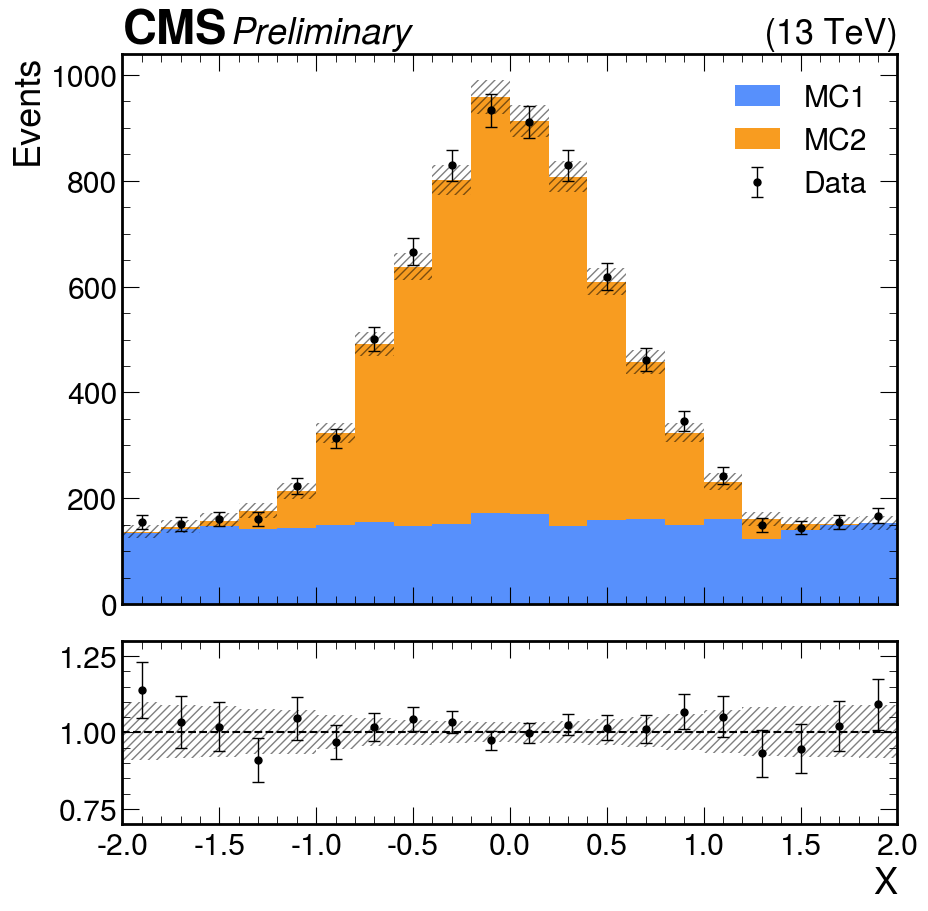

In [5]:
from hist.intervals import ratio_uncertainty

hep.style.use("CMS")
fig, (ax, rax) = plt.subplots(2, 1, gridspec_kw=dict(height_ratios=[3, 1], hspace=0.1), sharex=True)
hep.cms.label("Preliminary", data = True, loc=0, ax=ax);
ax.set_ylabel("Events")
rax.set_xlabel("X")

# Main plot
hep.histplot([a, b], ax=ax, stack=True, histtype='fill', label=["MC1", "MC2"])
hep.histplot(data, ax=ax, histtype='errorbar', color='k', capsize=4, yerr=True, label="Data")

# Error band
errps = {'hatch':'////', 'facecolor':'none', 'lw': 0, 'edgecolor': 'k', 'alpha': 0.5}
hep.histplot(sum([a, b]), histtype='band', ax=ax, **errps)

# Ratio panel
hep.histplot(data.values()/tot.values(), tot.axes[0].edges, yerr=np.sqrt(data.values())/tot.values(),
    ax=rax, histtype='errorbar', color='k', capsize=4, label="Data")
# Error band
yerr = ratio_uncertainty(data.values(), tot.values(), 'poisson')
rax.stairs(1+yerr[1], edges=tot.axes[0].edges, baseline=1-yerr[0], **errps)


rax.axhline(1, ls='--', color='k')
rax.set_ylim(0.7, 1.3)
ax.set_xlabel("")
ax.set_xlim(-2, 2)
ax.legend();

In the following, the main CMS recommendations will be reviewed, along with the handles to implement them in both aforementioned tools. To do so, let's first do some useful imports for the examples below.

## `cmsstyle`

In [6]:
f_ratio = ROOT.TFile.Open('test_file_ratio.root')
th1_names = [k.GetName() for k in f_ratio.GetListOfKeys()]
th1s = [f_ratio.Get(sample) for sample in th1_names]
bkg = th1s[0]
signal = th1s[1]
bkg_tot = th1s[2]
data = th1s[3]
#data.Scale(bkg_tot.Integral() / data.Integral())
data.Sumw2()
ratio = data.Clone("ratio")
ratio.Divide(bkg_tot)

True

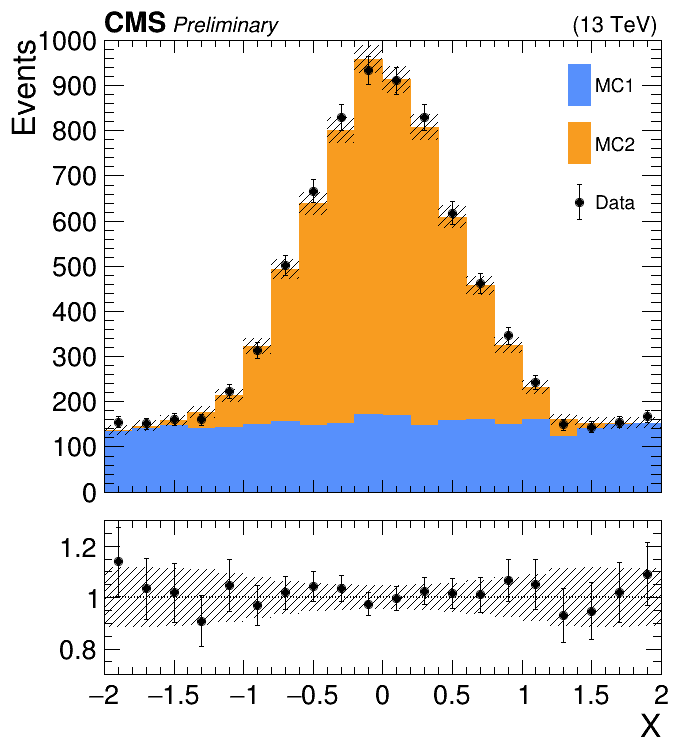

In [7]:
CMS.SetLumi("")
CMS.SetEnergy("13")
#CMS.ResetAdditionalInfo()
CMS.SetExtraText("Preliminary")
square=CMS.kSquare
iPos=0

# Takes care of fixing overlay and closing object

stack = ROOT.THStack("stack", "Stacked")
canv_name = "stack_ratio"
dicanv = CMS.cmsDiCanvas(canv_name, -2, 2, 0, 1000, 0.7, 1.3, "X", "Events", "", square=square, extraSpace=0.1, iPos=iPos,)
dicanv.cd(1)

h_err = bkg_tot.Clone("h_err")

leg = CMS.cmsLeg(0.81, 0.89 - 0.05 * 7, 0.99, 0.89, textSize=0.04)

CMS.cmsDrawStack(stack, leg, {"MC1": bkg, "MC2": signal})
leg.AddEntry(data, "Data", "pe")

CMS.cmsDraw(h_err, "e2same0", lcolor = 335, lwidth = 1, msize = 0, fcolor = ROOT.kBlack, fstyle = 3004,) 
CMS.cmsDraw(data, "E1X0", mcolor=ROOT.kBlack)

CMS.fixOverlay()

dicanv.cd(2)
leg_ratio = CMS.cmsLeg(
    0.17, 0.97 - 0.05 * 5, 0.35, 0.97, textSize=0.05, columns=2
)
# how alternative way to pass style options
#style = {"style": "hist", "lcolor": ROOT.kAzure + 2, "lwidth": 2, "fstyle": 0}

h_bkg_err = ratio.Clone("h_err")
h_bkg_err.Reset()
#h_bkg_err.Sumw2()
for i in range(1,ratio.GetNbinsX()+1):
    h_bkg_err.SetBinContent(i,1)
    if(ratio.GetBinContent(i)):
        h_bkg_err.SetBinError(i, (ratio.GetBinError(i)/ratio.GetBinContent(i)))

    else:
        h_bkg_err.SetBinError(i, 10^(-99))
CMS.cmsDraw(h_bkg_err, "e2same0", lwidth = 100, msize = 0, fcolor = ROOT.kBlack, fstyle = 3004)  
CMS.cmsDraw(ratio, "E1X0", mcolor=ROOT.kBlack)

ref_line = ROOT.TLine(-2, 1, 2, 1)
CMS.cmsDrawLine(ref_line, lcolor=ROOT.kBlack, lstyle=ROOT.kDotted)